# Performance metrics
This notebook performs an analysis on the three metrics: AUROC and EF1 and BEDROC.

We study the linear relationship of the two metrics using our atom/surface-level ensemble (DENVIS) trained on PDBbind refined set.

Additionally, we plot an example of prediction scores for active/decoys for a single target using DENVIS. We show that for, some cases, it is possible that the active/decoy distributions overlapin the low score range but be clearly separated in the higher range, thus leading to high EF1 scores.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import ensembling
import metrics
import parsing
import postprocessing

# 1. Configuration

In [2]:
AVG_FUN = np.nanmedian  # Reduce function to compute averages across targets. Using nanmedian because there is one target missing from RF/NN-score
EF_ALPHA = 0.01 # alpha for EF metric (i.e., EF1)
BEDROC_ALPHA = 80.5 # alpha for BedROC metric (i.e, BedROC80.5)

DATASET = 'DUD-E'

PATH_RESULTS = {
    'atom': '../data/outputs/denvis_outputs/dude_main_refined_atom.parquet',
    'surface': '../data/outputs/denvis_outputs/dude_main_refined_surface.parquet'}

# 2. Parse results

In [3]:
results, results_cache = dict(), dict()
for protein_model, path in PATH_RESULTS.items():
    results_tmp, _ = parsing.parse_results_denvis(path)
    results_tmp = ensembling.compute_ensemble_scores(results_tmp, version=True)
    results_cache[protein_model] = results_tmp  # Will be used for computing atom/surface-level ensemble scores
    results[protein_model] = postprocessing.combine_outputs(results_tmp, y_aff_weight=0.0, y_kd_weight=0.5, y_ki_weight=0.5, y_ic50_weight=0.0, use_clf=False)

# Atom/surface ensemble
results['ensemble'] = ensembling.compute_level_ensemble_scores(results_cache['atom'], results_cache['surface'], atom_weight=0.5, use_target_intersection=False)
results['ensemble'] = postprocessing.combine_outputs(results['ensemble'], y_aff_weight=0.0, y_kd_weight=0.5, y_ki_weight=0.5, y_ic50_weight=0.0, use_clf=False)

# 3. Performance scores

In [4]:
auroc_pt, auroc_micro = dict(), dict()  # Keys are models
ef1_pt, ef1_micro = dict(), dict()  # Keys are models
bedroc_pt, bedroc_micro = dict(), dict()  # Keys are models

for model, result in results.items():
    auroc_pt[model], auroc_micro[model] = metrics.compute_auroc_scores(result, avg_fun=AVG_FUN)
    ef1_pt[model], ef1_micro[model] = metrics.compute_ef_scores(result, alpha=EF_ALPHA, avg_fun=AVG_FUN)
    bedroc_pt[model], bedroc_micro[model] = metrics.compute_bedroc_scores(result, alpha=BEDROC_ALPHA, avg_fun=AVG_FUN)

# Tidy-format
tf_df = pd.DataFrame(columns=['Model', 'Target', 'AUROC', 'EF1', 'BEDROC80.5'])
for model in results:
    for target in auroc_pt[model].keys():
        new_entry = pd.DataFrame({
            'Model': [model],
            'Target': [target],
            'AUROC': [auroc_pt[model][target]],
            'EF1': [ef1_pt[model][target]],
            'BEDROC80.5': [bedroc_pt[model][target]]})
        tf_df = pd.concat((tf_df, new_entry), axis='index')
tf_df.reset_index(inplace=True)

# 4. Scatter plot comparisons & active/decoy distributions for a single target (Figure 7)

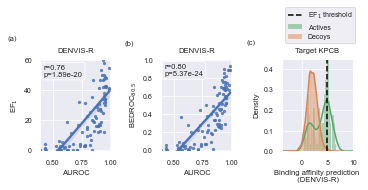


 AUROC 0.78 and EF1 31.1 and BEDROC80.5 0.50


In [5]:
pdb = 'kpcb'

font_scale = 0.8
lw = 1.5
figsize = (5.6,1.7)
marker_size = 5
bins = 30
xlim_regplot = [0.39, 1.01]
ylim_regplot_ef1 = [-1, 61]
ylim_regplot_bedroc = [-0.01, 1.01]
inset_x_ef1 = 0.42
inset_y_ef1 = 49
inset_x_bedroc = 0.42
inset_y_bedroc = 0.82
xlim_distplot = [-4,10]
ylim_distplot = [0., 0.45]
truncate = True
kde_kws = {'cut': 10}

sns.set_context("paper", font_scale=font_scale, rc={"lines.linewidth": lw})
f, axes = plt.subplots(1, 3, figsize=figsize)

# EF1 vs AUROC
auroc_ens = tf_df[tf_df['Model'] == 'ensemble']['AUROC']
ef1_ens = tf_df[tf_df['Model'] == 'ensemble']['EF1']
r0, p0 = sp.stats.pearsonr(x=auroc_ens, y=ef1_ens)
sns.regplot(x=auroc_ens, y=ef1_ens, ax=axes[0], scatter_kws={'s': marker_size},
            truncate=truncate, label=f'r={r0:0.2f}\n p={p0:.2e}')
axes[0].set_title('DENVIS-R')
axes[0].set_ylabel(r'EF$_{1}$')
axes[0].set_xlim(xlim_regplot)
axes[0].set_ylim(ylim_regplot_ef1)
handles, labels = axes[0].get_legend_handles_labels()
props = dict(boxstyle='round', facecolor='#EAEAF2', alpha=1)
axes[0].text(x=inset_x_ef1, y=inset_y_ef1, s=f'r={r0:0.2f}\np={p0:.2e}', bbox=props)

# BEDROC vs AUROC
auroc_ens = tf_df[tf_df['Model'] == 'ensemble']['AUROC']
bedroc_ens = tf_df[tf_df['Model'] == 'ensemble']['BEDROC80.5']
r1, p1 = sp.stats.pearsonr(x=auroc_ens, y=bedroc_ens)
sns.regplot(x=auroc_ens, y=bedroc_ens, ax=axes[1], scatter_kws={'s': marker_size},
            truncate=truncate, label=f'r={r1:0.2f}, p={p1:.2e}',
            color=sns.color_palette()[0])
axes[1].set_title('DENVIS-R')
axes[1].set_ylabel(r'BEDROC$_{80.5}$')
axes[1].set_xlim(xlim_regplot)
axes[1].set_ylim(ylim_regplot_bedroc)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].text(x=inset_x_bedroc, y=inset_y_bedroc, s=f'r={r1:0.2f}\np={p1:.2e}', bbox=props)

# Distplot for active/decoys
results_ens = results['ensemble']
ef_top_percentile = results_ens[results_ens['target_id'] == pdb]['y_score'].quantile(1. - EF_ALPHA)
sns.histplot(x=results_ens[(results_ens['target_id']==pdb) & (results_ens['y_true'])]['y_score'], 
             label='Actives',
             bins=bins,
             stat="density",
             kde=True,
             kde_kws=kde_kws,
             common_norm=False, 
             ax=axes[2],
             color=sns.color_palette(n_colors=3)[2])
sns.histplot(x=results_ens[(results_ens['target_id']==pdb) & ~(results_ens['y_true'])]['y_score'],
             label='Decoys',
             bins=bins,
             kde=True,
             kde_kws=kde_kws,
             stat="density",
             common_norm=False,
             ax=axes[2],
             color=sns.color_palette(n_colors=3)[1])
axes[2].set_xlabel('Binding affinity prediction \n (DENVIS-R)')
axes[2].set_ylabel('Density')
axes[2].set_xlim(xlim_distplot)
axes[2].set_ylim(ylim_distplot)
axes[2].axvline(x=ef_top_percentile, ls='--', c='black', label=r'EF$_{1}$ threshold')
axes[2].set_title(f'Target {pdb.upper()}')
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles=handles, bbox_to_anchor=(0, 1.6), loc='upper left',
           labels = labels)

axes[0].text(x=0.1, y=73, s='(a)')
axes[1].text(x=0.07, y=1.15, s='(b)')
axes[2].text(x=-11, y=0.52, s='(c)')

plt.subplots_adjust(wspace=0.7)
plt.show()
print('\n AUROC '
      f'{tf_df[(tf_df["Model"] == "ensemble") & (tf_df["Target"] == pdb)]["AUROC"].iloc[0]:.2f} and ' + r'EF1 '
      f'{tf_df[(tf_df["Model"] == "ensemble") & (tf_df["Target"] == pdb)]["EF1"].iloc[0]:.1f} and ' + r'BEDROC80.5 '
      f'{tf_df[(tf_df["Model"] == "ensemble") & (tf_df["Target"] == pdb)]["BEDROC80.5"].iloc[0]:.2f}' )